소프트맥스(Softmax) → 로그소프트맥스(Log-Softmax) → NLLLoss

[ 용어만 딱 정리 ]

- 로짓(logit): 모델이 내는 “점수(원시 출력)”. 아직 확률 아님.

- 소프트맥스(softmax): 로짓들을 확률로 바꿔줌. (모든 확률 합 = 1)

- 로그소프트맥스(log_softmax): 확률의 로그값을 안정적으로 계산.

- NLLLoss(음의 로그 가능도): 정답 클래스의 확률이 낮을수록 큰 벌점


- NLL=−log(p정답​)

- CrossEntropyLoss(크로스 엔트로피): log_softmax + NLLLoss를 한 번에 해주는 버전.

[ 상황 ]

분류 클래스: 고양이(0), 강아지(1), 토끼(2) (총 3개)

모델 로짓(점수):
[2,1, 0]

- 가장 점수가 큰 고양이(0) 쪽으로 모델이 기우는 중

- 로짓(logit) → 소프트맥스(확률) 변환

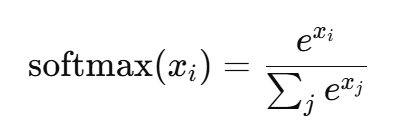

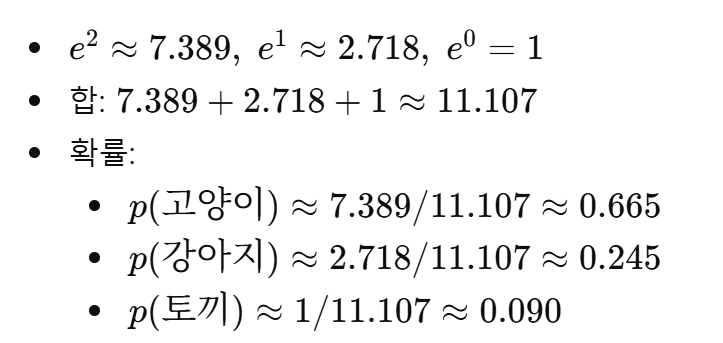

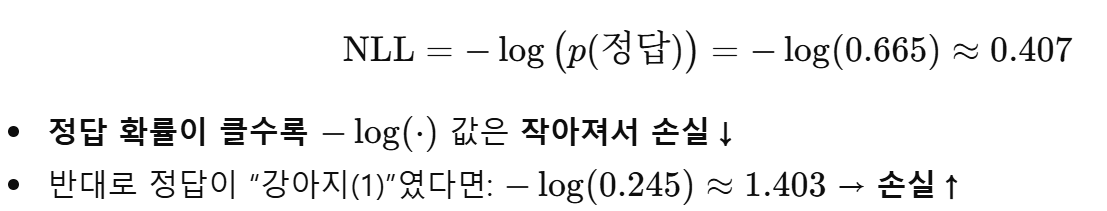

즉, 정답을 얼마만큼 “자신 있게” 맞췄는지를 수치로 매기는 페널티.

왜 log_softmax를 쓰나? (수치 안정성)

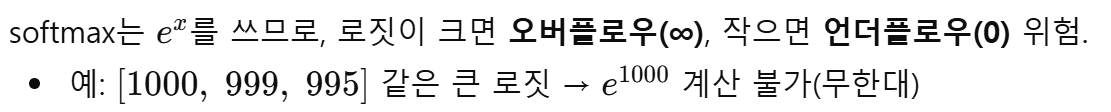

실무에서는 log_softmax → NLLLoss 또는 CrossEntropyLoss(둘 합친 것)를 씀.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 1) 로짓: [고양이, 강아지, 토끼]
logits = torch.tensor([[2.0, 1.0, 0.0]])  # 배치=1, 클래스=3
target = torch.tensor([0])  # 정답: 고양이(인덱스 0)

# softmax → 확률 → NLL 수동 계산 -----------------
probs = F.softmax(logits, dim=1)     # 확률값
p_true = probs[0, target]            # 정답 클래스 확률만 뽑기
loss_manual = -torch.log(p_true)     # NLL = -log(p_true)

print("A) 수동 NLL =", loss_manual.item())  # ≈ 0.407 (위에서 손계산과 거의 동일)

# --- (B) 안전한 방식: log_softmax → NLLLoss ------------------------
log_probs = F.log_softmax(logits, dim=1)  # 로그확률(수치안정)
nll = nn.NLLLoss(reduction='mean')        # 배치 평균(기본)
loss_nll = nll(log_probs, target)

print("B) NLLLoss(log_softmax 입력) =", loss_nll.item())  # A와 사실상 동일

# --- (C) 제일 실무적인 방식: CrossEntropyLoss (= log_softmax + NLLLoss)
ce = nn.CrossEntropyLoss(reduction='mean')
loss_ce = ce(logits, target)

print("C) CrossEntropyLoss =", loss_ce.item())  # A, B와 동일


In [ ]:
# 큰 로짓(overflow 위험한 예)
big_logits = torch.tensor([[1000.0, 999.0, 995.0]])
target = torch.tensor([0])

#  위험: softmax → log (오버플로우/NaN 가능)
try:
    probs_bad = F.softmax(big_logits, dim=1)  # e^1000 계산 중 터질 수 있음
    loss_bad = -torch.log(probs_bad[0, target])
    print("Naive NLL with big logits =", loss_bad.item())
except Exception as e:
    print("Naive 방식에서 문제 발생:", e)

# 안전: log_softmax → NLLLoss (내부에 log-sum-exp trick)
log_probs_safe = F.log_softmax(big_logits, dim=1)
loss_safe = nn.NLLLoss()(log_probs_safe, target)
print("안전한 NLL with big logits =", loss_safe.item())

# 더 간단: CrossEntropyLoss
loss_ce_safe = nn.CrossEntropyLoss()(big_logits, target)
print("안전한 CE with big logits =", loss_ce_safe.item())


In [ ]:
# 배치 2개, 클래스 3개
logits = torch.tensor([[2.0, 1.0, 0.0],   # 샘플1 (정답=0)
                       [0.5, 0.2, 1.5]])  # 샘플2 (정답=2)
targets = torch.tensor([0, 2])

# (1) 수동 계산 (학습용 직관)
probs = F.softmax(logits, dim=1)
p_true = probs[torch.arange(len(targets)), targets]  # 각 샘플 정답확률
loss_each = -torch.log(p_true)                       # 각 샘플 NLL
loss_mean_manual = loss_each.mean()                  # 배치 평균

print("배치 수동 NLL 평균 =", loss_mean_manual.item())

# (2) 실전: CrossEntropyLoss 한 줄
loss_ce = nn.CrossEntropyLoss()(logits, targets)
print("배치 CrossEntropyLoss =", loss_ce.item())  # 위와 동일


KL Divergence란?

확률분포 두 개가 얼마나 다른지(차이)를 재는 척도

- 진짜 분포인 (P) 와 모델이 예측한 분포(Q) 가 얼마나 비슷한가? 를 측정하는 수학적인 거리(distance) 임

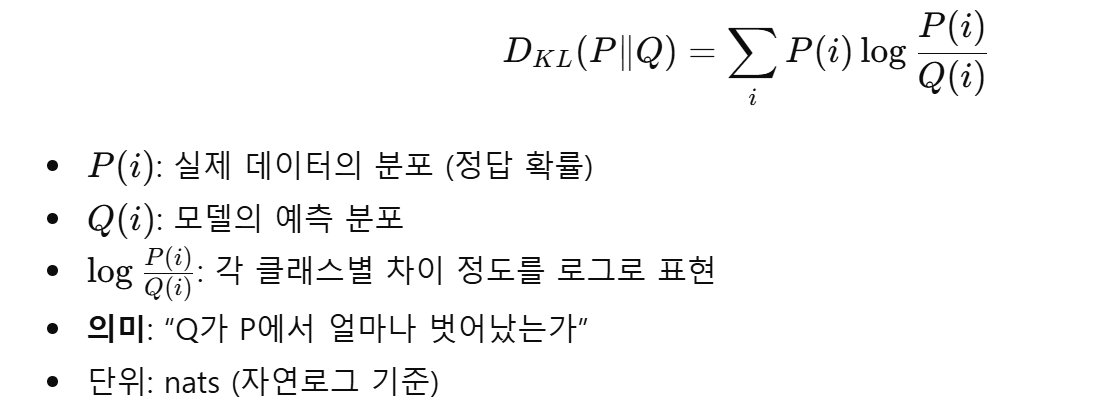

[예시]

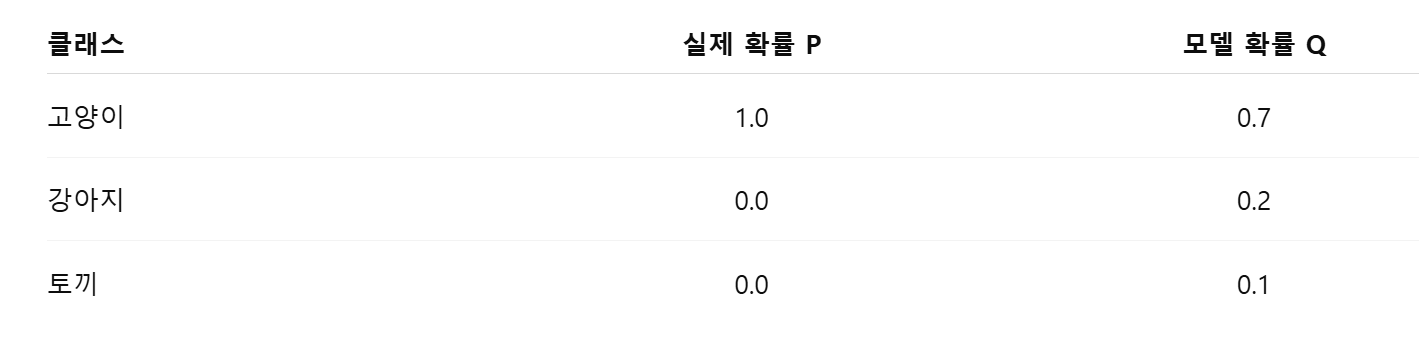

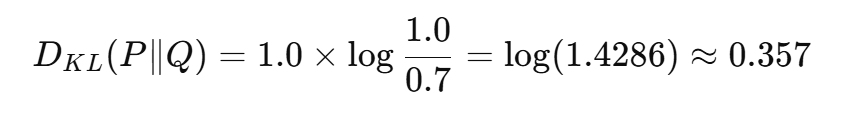

KL 값이 0.357 >> 즉 작을 수록 비슷하기 때문에 좋다는 의미임

완전히 같으면 KL = 0

In [ ]:
import torch
import torch.nn.functional as F

# 실제 확률분포 P (정답)
P = torch.tensor([1.0, 0.0, 0.0])
# 고양이 100% 확률 (정답: 고양이)

# 모델 예측 확률분포 Q
Q = torch.tensor([0.7, 0.2, 0.1])

# log 변환 (KLDivLoss는 로그 확률 입력 필요)
log_Q = torch.log(Q)
# 로그 확률로 변환(수치 안정성)

# KL Divergence 계산
kl_div = F.kl_div(log_Q, P, reduction='sum')
# 기본은 평균(mean)이지만 합으로(원래 정의가 합임)
# >> KL Divergence 는 확률분포 간 거리
# 즉, 각 클래스의 확률 차이를 모두 더해서 전체적인 차이 정도를 보는 개념
# 근데 왜 평균(mean)이 기본이야? (딥러닝 학습)
# 모델 훈련시 배치마다 샘플 수가 다를 수 있기 때문
# >> 배치 크기에 상관없이 일정한 손실 규모 유지
print("KL Divergence:", kl_div.item())


In [ ]:
# eos